# Single target regression from ROOT file

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

In [2]:
from pathlib import Path
PATH = Path('./data')

## Data preparation

### Data import from ROOT file 
Use uproot to import the ROOT data into a pandas dataframe.
Example data is for the process $pp\rightarrow hh\rightarrow b\bar{b}\,\tau\bar{\tau}\rightarrow b\bar{b}\,\tau_h\mu$

In [3]:
import uproot
df = uproot.open(PATH/'signal.root')['tree'].pandas.df()

In [4]:
df.head()

,t_0_pT,t_0_eta,t_0_phi,t_0_mass,t_1_pT,t_1_eta,t_1_phi,t_1_mass,b_0_pT,b_0_eta,...,gen_h_bb_eta,gen_h_bb_phi,gen_h_bb_E,gen_h_tt_pT,gen_h_tt_eta,gen_h_tt_phi,gen_h_tt_E,gen_mctMatch,gen_weight,gen_target
0,36.850742,-1.301508,-0.449490,3.583080e+00,88.756241,-0.045828,0.801673,0.105658,101.773132,-0.621864,...,-0.366014,-2.261545,193.133926,167.054816,-0.364203,0.617325,217.716858,1.0,1.0,1.0
1,44.549965,1.641584,2.540022,1.228315e+00,68.820755,1.131779,-2.750534,0.105658,198.545624,1.155151,...,1.094840,-0.055264,477.111084,205.618939,1.476620,3.140846,489.813568,1.0,1.0,1.0
2,32.312160,0.225592,-2.485713,7.742898e-01,73.520073,0.495276,1.294261,0.105658,344.611084,0.085861,...,-0.034175,-0.278533,399.206879,66.369413,0.820306,1.702539,154.017578,1.0,1.0,1.0
3,55.896526,-1.680148,1.079537,4.889964e+00,32.492466,-1.598684,2.668608,0.105658,92.599792,-2.158637,...,-1.933018,-0.814522,517.224487,141.165349,-1.903520,2.270204,499.970337,1.0,1.0,1.0
4,47.391769,0.881903,2.025714,9.536743e-07,95.349663,0.173650,2.977873,0.105658,154.887131,0.073108,...,-0.028465,-0.835442,382.160492,253.092701,0.351680,2.796669,296.538849,1.0,1.0,1.0


Since only the $\mu+\tau_h$ decay channel is used, $t_1$ has a constant mass (muon mass), so we can simply drop it.

In [5]:
df.drop(columns=['t_1_mass'], inplace=True)

The data also contains events where the incorect final-states were chosen, since we need the reconstructed and generator-level objects to match for correct regression, we only want to train on the correctly selected events (gen_mctMatch == True)

In [6]:
df = df[df.gen_mctMatch == 1]; len(df)

61405

We can now check how poorly the reconstructed di-Higgs mass matches to the true mass

In [7]:
df['gen_delta'] = df['diH_mass']-df['gen_diH_mass']

`plot_feat` is a flexible function to provide indicative information about the 1D distribution of a feature. By default it will produce a weighted KDE+histogram for the [1,99] percentile of the data, as well as compute the mean and standard deviation of the data in this region. By passing a list of cuts and labels, it will plot multiple distributions of the same feature for different cuts. Since it is designed to provide quick, indicative information, more specific functions (such as `plot_kdes_from_bs`) should be used to provide final results.

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


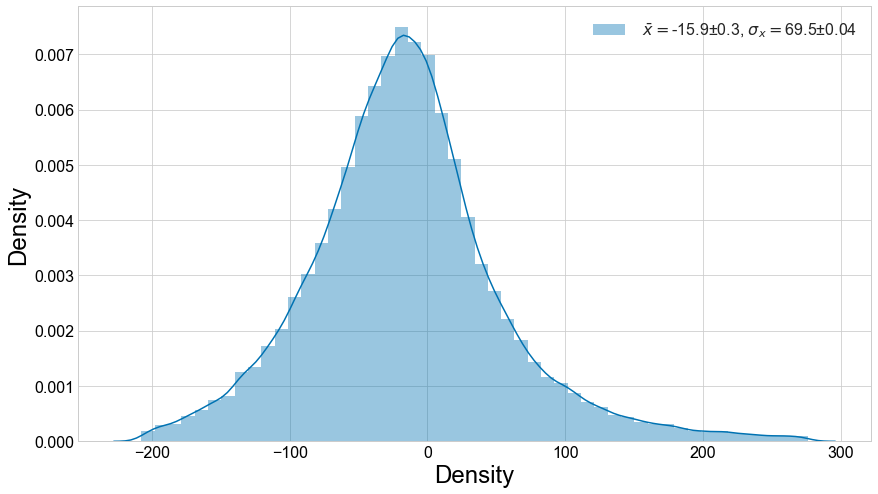

In [8]:
from lumin.plotting.data_viewing import plot_feat
plot_feat(df, 'gen_delta')

### Preprocessing
Having imported the ROOT data, we now need to further process it into form suitable for training the regressor.

We can start by moving a Cartesian coordinate system; the HEP standard of $p_T,\ \eta,\ \phi$ can be a bit tricky, since $\phi$ is cyclical in nature, and $\eta$ is highly non-linear. Additionally, since the di-Higgs mass is invariant under transformations of the absolute orientation of each event, we can remove several symetries in the data by rotating each event to have the same orientation.

`proc_event` has options to set all events to have `ref_vec_0` at $\phi=0$ and be always in the positive $\eta$ region. The remaining symmetry of transverse reflection can be fixed by setting `ref_vec_1` to be in the positive $\phi$ region. The vectors can then transformed into Cartesian system via `use_cartesian` flag. The original vectors are automatically dropped, but can be kept if added to `keep_feat`. It can sometimes be useful to keep the absolute amount of $p_T^{\mathrm{miss}}$, since this is now non-linear combination of $p_x^{\mathrm{miss}}$ and $p_y^{\mathrm{miss}}$.

In [9]:
from lumin.data_processing.hep_proc import proc_event
proc_event(df, use_cartesian=True, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='t_0', ref_vec_1='t_1', keep_feats=['mPT_pT'])

Setting t_0 to phi = 0
Setting t_1 to positve phi
Setting t_0 to positive eta
eta component of mPT not found
Converting to use_cartesian coordinates


For quick access, we'll define here all the sets of features we'll later want use

In [10]:
targ_feat = 'gen_diH_mass'
gen_feats = [f for f in df.columns if 'gen_' in f]
cat_feats = [f for f in df.columns if f.startswith('n') if f != 'nPhotons']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

3 ['nJets', 'nBJets', 'nTauJets']
55 ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'hT', 'sT', 'centrality', 'eVis', 'minJetPT', 'meanJetPT', 'maxJetPT', 'minJetMass', 'meanJetMass', 'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'nPhotons', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA', 'dShapeA', 'sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 'upsilonP', 'dShapeP', 't_0_px', 't_0_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'mPT_px', 'mPT_py', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 'diH_px', 'diH_py', 'diH_pz', 't_1_px', 't_1_py', 't_1_pz', 'mPT_pT']


Several of the categorical features display long tails, making it difficult to ensure decent population. We're perhaps more interest in whether events contain few, several, or lots of jets, rather that the exact number, so we'll simply cut to the tails and more the last category to be $x$ or greater.

In [11]:
df.loc[df.nJets >= 5, 'nJets'] = 4
df.loc[df.nBJets >= 5, 'nBJets'] = 4
for f in cat_feats:
    s = set(df[f])
    print(f, len(s), s)

nJets 2 {3.0, 4.0}
nBJets 3 {2.0, 3.0, 4.0}
nTauJets 3 {1.0, 2.0, 3.0}


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [12]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[cat_feats].values)

In [13]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
df.columns[df.isna().any()].tolist()

[]

#### Train-validation split 

In [15]:
from sklearn.model_selection import train_test_split 
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key)

Having pulled out a stratified random subsample, we can check whether it really is representative of the train data (and our test set if we had one) by seeing whether we can use the input features to identify which dataset each event belongs to. If there our some features which allow the sets to be identified, then we could remove them from the inputs to improve the generalisation of the model.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [19]:
from lumin.utils.data import check_val_set
check_val_set(train_df, val_df)


AUC for train-validation discrimination = 0.5023150018557188
Top 10 most important features are:
   index      Feature  Importance
0      0       mPT_pT    0.008430
1      1     b_0_mass    0.008182
2      2      dShapeA    0.007563
3      3    meanJetPT    0.006943
4      4       diH_px    0.006695
5      5       b_0_py    0.006571
6      6   meanJetEta    0.006199
7      7  sphericityP    0.005827
8      8  meanJetMass    0.005207
9      9      dShapeP    0.004587


#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [20]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(train_df, cont_feats, PATH)

In [21]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [22]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df)
cat_maps, cat_szs

(OrderedDict([('nJets', {0: 3.0, 1: 4.0}),
              ('nBJets', {0: 2.0, 1: 3.0, 2: 4.0}),
              ('nTauJets', {0: 1.0, 1: 2.0, 2: 3.0})]),
 OrderedDict([('nJets', 2), ('nBJets', 3), ('nTauJets', 3)]))

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

In [23]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

Saving fold: 0 with 4914 events
Saving fold: 1 with 4915 events
Saving fold: 2 with 4915 events
Saving fold: 3 with 4914 events
Saving fold: 4 with 4913 events
Saving fold: 5 with 4912 events
Saving fold: 6 with 4912 events
Saving fold: 7 with 4912 events
Saving fold: 8 with 4909 events
Saving fold: 9 with 4908 events


In [24]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

Saving fold: 0 with 1230 events
Saving fold: 1 with 1230 events
Saving fold: 2 with 1228 events
Saving fold: 3 with 1229 events
Saving fold: 4 with 1228 events
Saving fold: 5 with 1228 events
Saving fold: 6 with 1227 events
Saving fold: 7 with 1227 events
Saving fold: 8 with 1228 events
Saving fold: 9 with 1226 events


## Feature selection

Currently we're using all of the available information from the ROOT file, however it contains an awful lot of high-level features which may not be useful for the regression. We can run a few checks to try and filter out the uneeded features.

`FoldYielder` is the base class we'll use to pull data from the h5py file. We can also recover the original dataframe via `get_df`, and deporcess it my adding the input pipe.

In [25]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

49124 candidates loaded


,t_0_mass,b_0_mass,b_1_mass,h_tt_mass,h_bb_mass,diH_mass,hT,sT,centrality,eVis,...,diH_py,diH_pz,t_1_px,t_1_py,t_1_pz,mPT_pT,nJets,nBJets,nTauJets,gen_target
0,4.410120,16.697281,13.357175,153.978546,151.454391,475.819366,316.021942,502.589569,0.630579,533.359436,...,-15.662423,354.598236,19.844599,15.511989,22.521070,161.379715,1.0,0.0,0.0,396.926361
1,0.000001,33.631935,7.227210,119.777473,127.714684,407.808655,492.123230,560.098816,0.638596,850.725220,...,48.782925,-181.112518,-54.945477,18.819294,29.007900,9.896618,1.0,0.0,0.0,427.752045
2,1.817759,16.902903,11.056087,143.336227,114.252213,696.787415,797.166687,959.854919,0.271856,3169.371094,...,2.564148,1120.117432,31.910501,63.745674,66.598724,91.401512,1.0,0.0,0.0,625.834106
3,5.727513,13.131482,11.938969,89.615585,102.447136,352.568207,267.354492,361.035980,0.574201,544.450928,...,33.322418,174.485611,38.339710,30.246012,-23.974470,44.847542,1.0,0.0,0.0,488.548828
4,5.896853,30.414080,18.575914,397.409241,134.739990,962.254150,548.899353,859.926392,0.525363,1318.360840,...,-15.603452,491.012970,-47.449574,140.386765,432.912506,162.838318,1.0,0.0,0.0,1025.427856


A first step can be to check for duplication of information via similar features. `plot_dendrogram` uses Spearman's rank correlation and hierarchical clustering to group features by similarity. From right to left, features which are combined closer to the left are more similar, and it is worth checking whether one of a pair of features which are combined straight away can be safely removed (**N.B.** one of the features of a close clustering has to remain to otherwise the information of the pair is lost).

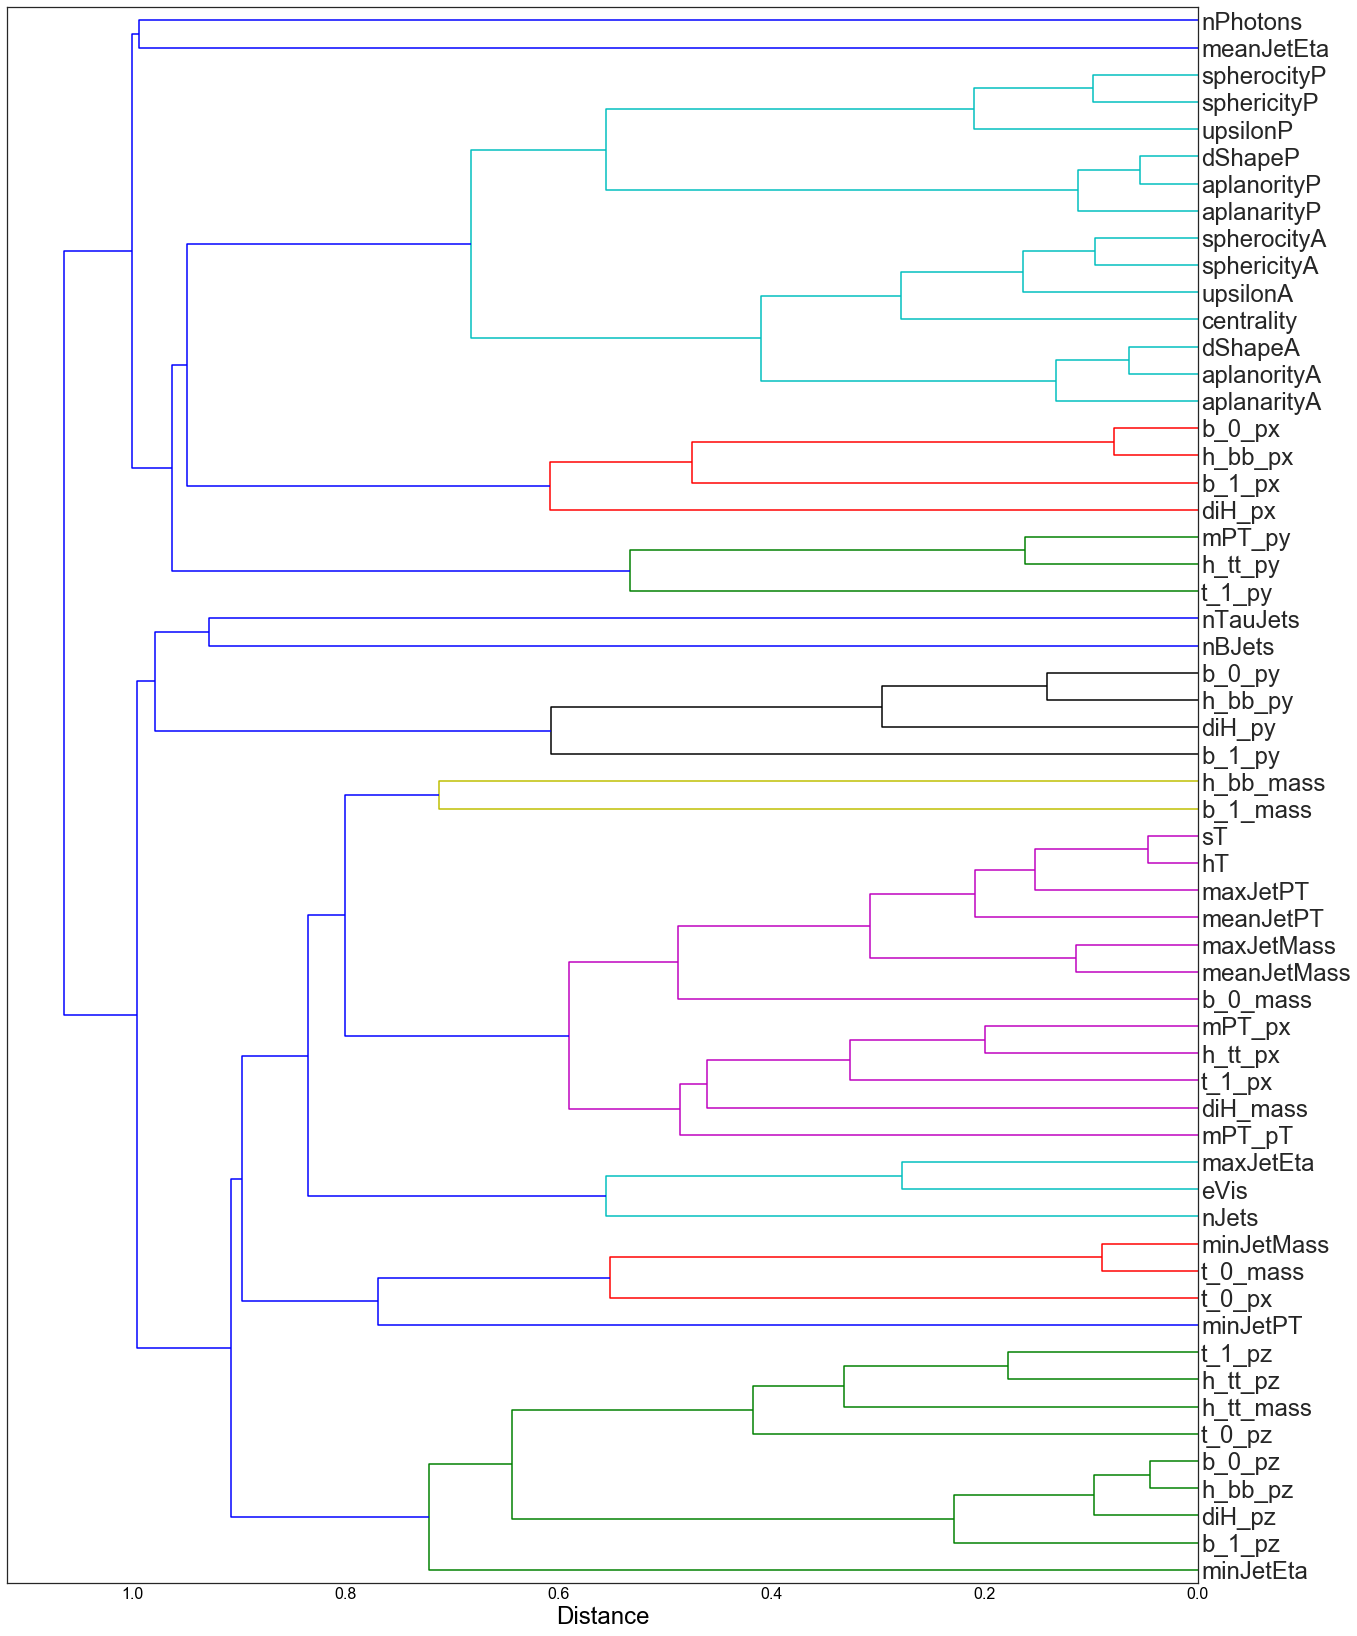

In [26]:
from lumin.plotting.data_viewing import plot_dendrogram
plot_dendrogram(train_df[train_feats])

None of the features get clustered straight away, so each feature contains at least some unique information. For further tests we'll want to split of another, temporary validation set

In [27]:
df_trn, df_val = train_test_split(train_df, test_size=0.8)

We're mainly interested in filtering down the high-level features, and will assume that the random forests we'll be using will not be able to make as much use of the lower level information as the neural networks will, so we'll only test the high level features and add regularisation as necessary later.

In [29]:
vec_feats = []
for c in ['px', 'py', 'pz', 'mass']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats)

28

In [30]:
hl_feats = [f for f in train_feats if f not in vec_feats]; len(hl_feats)

30

Let's see which of the high-level features the RFs find useful. `rf_rank_features` wraps rfpimp and initially trains a RF using the data and eveluates it on the validation set. It then sequentially makes a copy of the data and randomises the order of one of the fetaures and then reevaluates the model performance, and compares it to the original score. If their is a large decrease in the score, then the feature which was randomised was very important in the model. If there is only a small decrease (or increase) in the score, then the feature was not important.

Having established the importance of the features, `rf_rank_features` then runs another training only using the features with importances higher the the `cut` argument. If there is no decrease in the score, the ignored features can probably be safely removed.

Optimising RF


Top ten most important features:
        Feature  Importance
0           sT    0.243713
1       mPT_pT    0.112071
2  aplanorityP    0.064603
3  spherocityP    0.064204
4    meanJetPT    0.061863
5      dShapeP    0.051316
6     maxJetPT    0.051020
7           hT    0.037483
8  aplanorityA    0.027094
9   centrality    0.018894


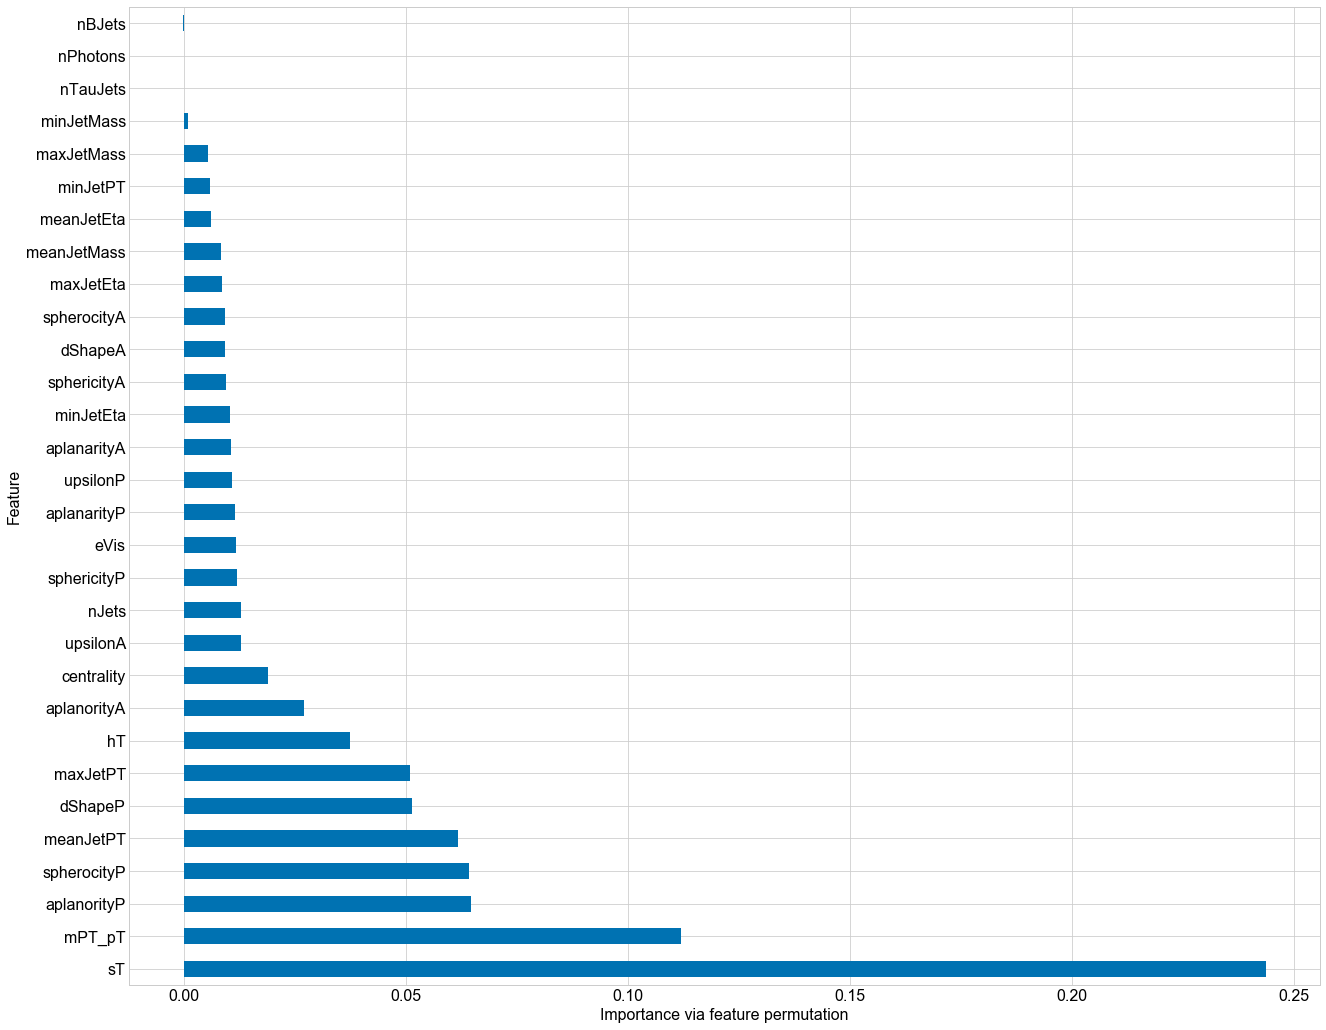


26 features found with importance greater than 0.001:
 ['sT', 'mPT_pT', 'aplanorityP', 'spherocityP', 'meanJetPT', 'dShapeP', 'maxJetPT', 'hT', 'aplanorityA', 'centrality', 'upsilonA', 'nJets', 'sphericityP', 'eVis', 'aplanarityP', 'upsilonP', 'aplanarityA', 'minJetEta', 'sphericityA', 'dShapeA', 'spherocityA', 'maxJetEta', 'meanJetMass', 'meanJetEta', 'minJetPT', 'maxJetMass']

Optimising new RF


Comparing RF scores, higher = better
All features:	0.55826
Top features:	0.56281


In [31]:
from lumin.optimisation.features import rf_rank_features
import_feats = rf_rank_features(df_trn, df_val, objective='regression', train_feats=hl_feats, cut=0.001)

So, we managed to remove a few features with no decrease in score, however, the above method of permutation importance, does not account for the possibility of sets of features being correlated; features carrying mutual information can lead to them being assigned low importances since when one feature is randomised, the other makes up for it and performance remains the same. In reality we'd only want to remove one of these features, since removing both could lead to a drop in performance. `rfpimp` provides some useful functions for plotting the correlations between features, and to check feature dependence by seeing how easily random forests are able to regress to each input feature in turn using the other features as inputs.

In [32]:
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap

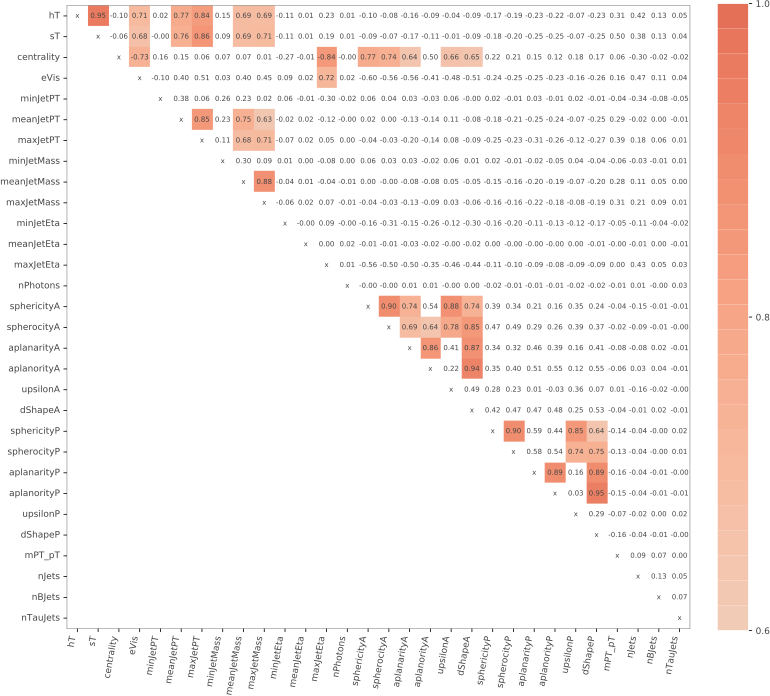

In [38]:
plot_corr_heatmap(df_trn[hl_feats], figsize=(11,11), label_fontsize=9, value_fontsize=7)

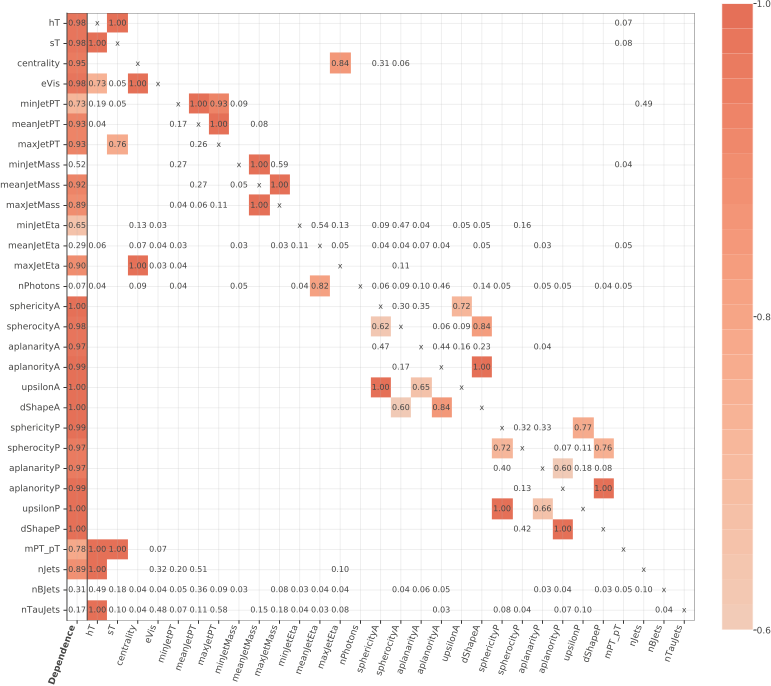

In [39]:
from sklearn.ensemble import RandomForestRegressor
D = feature_dependence_matrix(df_trn[hl_feats], sort_by_dependence=False, rfmodel=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True))
plot_dependence_heatmap(D, figsize=(11,10))

The first column 'Dependence' indicates how well a feature can be predicted using the other features (higher dependence = more easily predictable). The other columns indicate the relative importance of the features in predicting that feature.

We can see that upsilonA, dShapeA, upsilonP, and dShapeP can all be predicted perfectly by the other features and none these are important in predicting one of the features in this set, therefore it should be safe to remove them.

In [40]:
drop = ['upsilonA', 'dShapeA', 'upsilonP', 'dShapeP']

We'll create a list of features to ignore and then save all the feature lists for later use

In [41]:
ignore_feats = [f for f in train_feats if f not in vec_feats + import_feats or f in drop]; len(ignore_feats), ignore_feats

(8,
 ['minJetMass',
  'nPhotons',
  'upsilonA',
  'dShapeA',
  'upsilonP',
  'dShapeP',
  'nBJets',
  'nTauJets'])

In [42]:
with open(PATH/'feats.pkl', 'wb') as fout:
    pickle.dump({'targ_feats': targ_feat, 'cont_feats': cont_feats, 'cat_feats': cat_feats, 'cat_maps': cat_maps, 'cat_szs': cat_szs, 'ignore_feats': ignore_feats}, fout)

## Train regressor

Now we're ready to begin training the networked-based regressor. First we can load the feature sets, create a `FoldYielder` for the training data, and tell it to ignore the features we found to not be important.

In [43]:
with open(PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
    targ_feat = feats['targ_feats']
    cont_feats = feats['cont_feats']
    cat_feats = feats['cat_feats']    
    cat_maps = feats['cat_maps']    
    cat_szs = feats['cat_szs']    
    ignore_feats = feats['ignore_feats']
    train_feats = cont_feats + cat_feats
    
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [44]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.ignore(ignore_feats)

In [45]:
use_conts = [f for f in cont_feats if f not in ignore_feats]
use_cats = [f for f in cat_feats if f not in ignore_feats]

In [46]:
for f in [f for f in cat_feats if f not in use_cats]: cat_szs.pop(f)

The target feature spans quite a range and is at a scale far from zero, making it difficult to regress to. Rather than preprocess it, like the input features, we can instead use a sigmoid activation in the last layer and rescale it to match the target feature. To do this we need to know the range of the feature, and to also account for the training data not covering the full possible range.

In [47]:
targets = train_fy.get_column("targets")
y_range = (0.8*targets.min(), 1.2*targets.max()); y_range

(202.7258056640625, 2174.852197265625)

Here we define the architecture of the models, and how we want to train them. `ModelBuilder` takes arguments to define the network, loss, optimiser, and inputs and outputs and can then create networks on demand. These networks are provided as properties of the `Model` class which contains methods to train them, evaluate, predict, save/load, et cetera.
### ModelBuilder
Most of the parameters will use default values if not provided explicitly which can be viewed in the source code, e.g. `ModelBuilder.parse_cat_args`, `ModelBuilder.parse_loss`, `ModelBuilder.parse_model_args`, and `ModelBuilder.parse_opt_args`.
#### Architecture
The network consists of three parts: A head, which takes the inputs to the network; a body, which contains the majority of the hidden layers; and a tail which downscales the output of the body to match the desired number of outputs. The classes used for each can be specified 

By default the head is `CatEmbHead` which provides entity embeddings for categorical features (embedding sizes can be configured manually, or left as default `max(50,cardinality//2)`), and then a batch normalisation with the continuous inputs, with separate dropouts for embeddings and continuous inputs. These are then fed into a dense layer to scale up the connections to the model width parameter. More advanced classes, can be passed to the `ModelBuilder` head argument, or `ModelBuilder.get_head` overridden in an inheriting class.

The default body is a simple sequence of hidden layers (`FullyConnected`). These layers can optionally have dropout, batch normalisation, skip connections (residual network), or cumulative concatenations (dense network). The choice of class is set by `ModelBuldier`'s `body` argument, and built by `ModelBuilder.get_body`.

The tail (default `ClassRegMulti` set by `tail` argument/`ModelBuilder.get_tail`) uses a final dense layer to scale down the body output to match `n_out` and then applies an automatically selected activation according to `objective`:
- 'class*' or 'labelclass*' = sigmoid
- 'multiclass' = logsoftmax
- 'regression' and not `y_range` = linear
- 'regression' and `y_range` = sigmoid + offset and rescaling
#### Loss
This can either be passed as the `loss` argument of `ModelBuilder`, or be left to be automatically chosen according to `objective`:
- 'class*' or 'labelclass*' = Binary cross-entropy (`nn.BCELoss`)
- 'multiclass' = Weighted cross-entropy (`WeightedCCE`)
- 'regression' = Weighted mean-squared error (`WeightedMSE`, (`WeightedMAE` also exists but must be explicitly passed))

**N.B.** If a loss class is passed explicitly, it should be uninitialised to allow weights to be correctly handled.

`ModelBuilder.parse_loss` handles the automatic loss configuration.
#### Optimiser
Configured by `opt_args` argument of `ModelBuilder`, `ModelBuidler.parse_opt_args`, and `ModelBuilder.build_opt`. Currently only SGD and Adam are available. Choices of weight decay should be added in `opt_args`. The Learning rate can be set later via `ModelBuilder.set_lr`.

### Architecture
For our example architecture we'll use relu-based 4-layer deep resnet of width 100, with a bit of dropout. Note that even though we specify not to use batch normalisation (`bn`) it is still added where appropriate; after the embeddings are combined with the continuous inputs and after the skip connections. Requesting batch normalisation would additionally add it between the head and the body.

In [54]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model

bs = 128
objective = 'regression'
model_args = {'act':'relu', 'width':100, 'depth':4, 'res':True,
              'do_cat':0.005, 'do_cont':0.01, 'do':0.02, 'bn':False}
opt_args = {'opt':'adam', 'eps':1e-08}
n_cont_in=len(use_conts)
cat_args = {'n_cat_in':len(use_cats), 'cat_szs':[cat_szs[f] for f in cat_szs],
            'cat_names':[f for f in cat_szs], 'emb_szs':None}

n_out = 1
model_builder = ModelBuilder(objective, n_cont_in=len(use_conts), n_out=n_out, cat_args=cat_args, y_range=y_range,
                             model_args=model_args, opt_args=opt_args)

print("\nTraining on", len(use_conts), " continuous features:", [var for var in use_conts])
print("\nTraining on", len(use_cats), " categorical features:", [var for var in use_cats])
print('\n Model:')
print(Model(model_builder))


Training on 49  continuous features: ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'hT', 'sT', 'centrality', 'eVis', 'minJetPT', 'meanJetPT', 'maxJetPT', 'meanJetMass', 'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 't_0_px', 't_0_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'mPT_px', 'mPT_py', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 'diH_px', 'diH_py', 'diH_pz', 't_1_px', 't_1_py', 't_1_pz', 'mPT_pT']

Training on 1  categorical features: ['nJets']

 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): Sequential(
    (0): CatEmbHead(
      (embeds): ModuleList(
        (0): Embedding(2, 2)
      )
      (emd_do): Dropout(p=0.005)
      (do): Dropout(p=0.01)
      (bn): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequent

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `fold_lr_find`, runs several trainings using different folds of the data and then plots to mean and standard deviation of the loss.

LR finder took 1.304s 


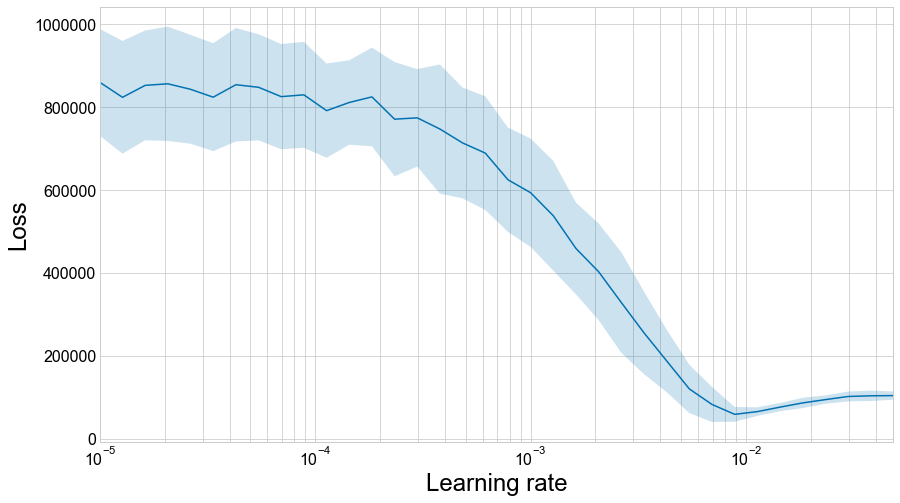

In [55]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

Looks like somewhere around 5e-3 should be good.

The training function takes several sets of callbacks, ways to alter the model's training schedule, to report more specialised results, to affect the earlystopping, and to keep track of model weights.

For this example we'll use [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026) to train an ensemble of models in a single training. This requires a linearly cycled LR with a short scale (about 4 sub-epochs per cycle). Snapshots of model are saved automatically after each cycle, so we can load them later to build our ensemble.

We'll also add an evaluation metric to calculate the (bootstrapped) standard deviation of the difference between the predicted di-Higgs masses and the true values

In [56]:
from lumin.nn.callbacks.cyclic_callbacks import CycleLR
from lumin.nn.metrics.reg_eval import RegPull

n_models = 1
patience = 10
max_epochs = 100

use_callbacks = [{'callback':CycleLR, 'kargs':{'lr_range': (4e-4, 4e-3), 'cycle_mult':1, 'interp':'linear', 'scale':4}}]
eval_metrics = {'Pull': RegPull(use_pull=False)}
plots = ['history', 'cycle']

`fold_train_ensemble` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of sub-epochs (or cycles) have elapsed with out an improvment of the validation loss. The model is then saved to `saveloc` to be loaded later. The function returns results of the training and model perfomance on validation fold. If an `AbsCyclicCallback` is used, then snapshots of the model weights are automatically saved after each cycle to allow for [Snapshot Ensembling](https://arxiv.org/abs/1704.00109) or [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026).

Training model 1 / 1


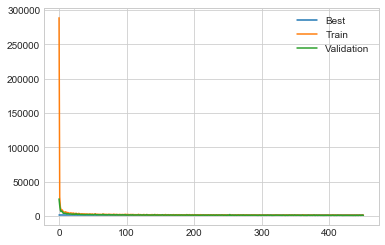

Early stopping after 452 epochs
Scores are: {'loss': 1072.8934326171875, 'Pull': 32.70130708331946}


<Figure size 432x288 with 0 Axes>

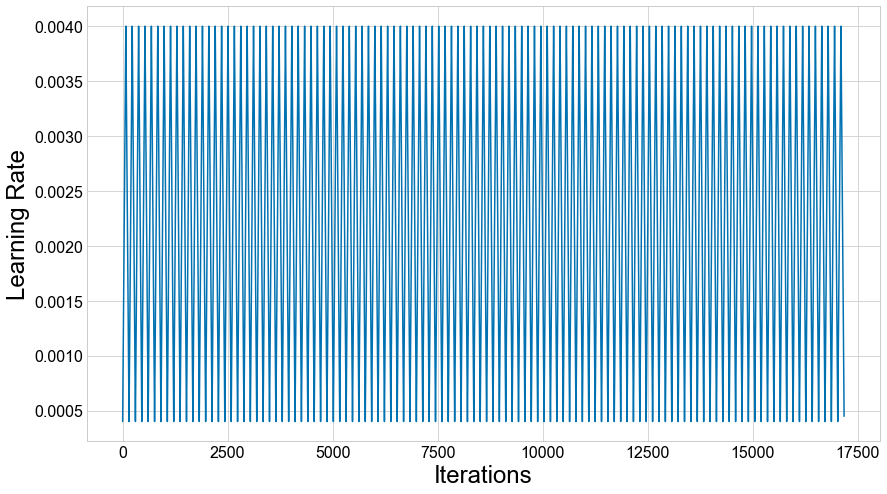

Fold took 110.907s


______________________________________
Training finished
Cross-validation took 110.910s 


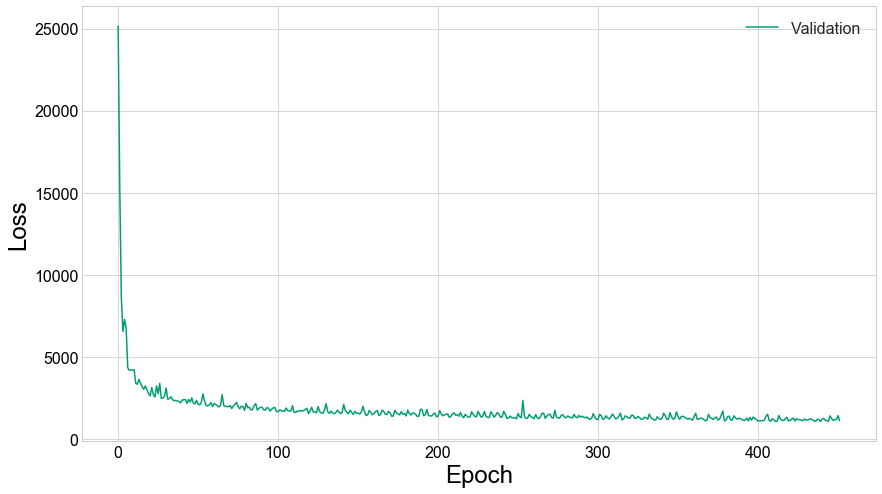

Mean loss = 1072.8934326171875±0.0
Mean Pull = 32.70130708331946±0.0
______________________________________



<Figure size 432x288 with 0 Axes>

In [57]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       use_callbacks=use_callbacks,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience,
                                                       plots=plots)

## Ensembling
Whilst we'd only trained one model, snapshots of the model were automatically saved due to specifying a cyclical callback. The validation losses of these are recorded in `cycle_losses`.

In [58]:
cycle_losses

[{1: 6552.14501953125,
  2: 4196.7138671875,
  3: 3400.67431640625,
  4: 3201.7294921875,
  5: 2776.05419921875,
  6: 2560.5537109375,
  7: 2473.73291015625,
  8: 2424.887451171875,
  9: 2341.0087890625,
  10: 2207.993408203125,
  11: 2179.27587890625,
  12: 2204.026123046875,
  13: 2084.3720703125,
  14: 2060.19677734375,
  15: 1980.0478515625,
  16: 1962.9482421875,
  17: 1984.748779296875,
  18: 1865.678955078125,
  19: 1973.6826171875,
  20: 1758.7435302734375,
  21: 1775.812744140625,
  22: 1766.8638916015625,
  23: 1782.8470458984375,
  24: 1716.5086669921875,
  25: 1671.003662109375,
  26: 1700.6292724609375,
  27: 1717.095947265625,
  28: 1628.26123046875,
  29: 1707.2635498046875,
  30: 1550.4337158203125,
  31: 1660.932373046875,
  32: 1588.6490478515625,
  33: 1676.181884765625,
  34: 1553.2100830078125,
  35: 1564.4661865234375,
  36: 1630.90283203125,
  37: 1509.8726806640625,
  38: 1532.781982421875,
  39: 1442.2442626953125,
  40: 1485.83056640625,
  41: 1452.64514160156

We can pass these to the ensemble to load up our FGE. The configuration for the ensembling of snapshots is set by the `snapshot_args` parameter. It needs the cycle losses, the patience (to avoid loading overfitted cycles), and the number of cycles to load. By default, the best performing state during training will also be loaded, but this can be avoided by requesting `load_cycles_only`. `weighting_pwr` can be used to assign lower weights to earlier snapshots according to `(n+1)**weighting_pwr`, where n is the number of cycles loaded so far.

In [106]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
snapshot_args = {'cycle_losses': cycle_losses, 'patience':patience,
                 'n_cycles':4, 'load_cycles_only':False, 'weighting_pwr':-0.5}
ensemble.build_ensemble(results, 1, model_builder, snapshot_args=snapshot_args)

Choosing ensemble by loss


Model 0 is 0 with loss = 1072.8934326171875
Model 0 cycle 102 has loss = 1126.88525390625 and weight 1.0
Model 0 cycle 101 has loss = 1123.6275634765625 and weight 0.7071067811865476
Model 0 cycle 100 has loss = 1191.278564453125 and weight 0.5773502691896257
Model 0 cycle 99 has loss = 1328.9364013671875 and weight 0.5


We can save our ensemble to be easily loaded later

In [107]:
name = 'weights/Single_Target_Regression'
ensemble.save(name, feats=train_feats, overwrite=True)

## Validation
Now we can test how well our ensemble performs on our validation set.

In [77]:
ensemble = Ensemble()
ensemble.load(name)

In [87]:
val_fy = FoldYielder(h5py.File(PATH/'val.hdf5', "r+"), cont_feats, cat_feats, ignore_feats=ignore_feats, input_pipe=input_pipe)

In [88]:
ensemble.predict(val_fy)

Mean time per event = 7.3115E-06±1.1206E-07


In [89]:
df = val_fy.get_df(inc_inputs=True, deprocess=True)

12281 candidates loaded


In [90]:
df.head()

,t_0_mass,b_0_mass,b_1_mass,h_tt_mass,h_bb_mass,diH_mass,hT,sT,centrality,eVis,...,diH_px,diH_py,diH_pz,t_1_px,t_1_py,t_1_pz,mPT_pT,nJets,gen_target,pred
0,2.733631,8.737084,7.357893,108.684296,115.931931,265.946228,226.605301,293.437195,0.353278,711.071838,...,9.064378,42.505657,92.239738,-1.145500,26.705246,94.237900,40.102066,1.0,342.904175,350.960419
1,4.786775,91.678032,5.726056,101.146255,123.193726,597.550537,984.617615,1111.494507,0.668956,1482.331543,...,-14.524169,-241.614609,278.894897,5.384529,22.163363,-22.540945,104.068748,1.0,571.237122,583.056091
2,1.153337,34.877552,9.537910,87.557434,116.188385,746.062134,342.556885,623.177185,0.562954,823.419922,...,35.019001,31.805412,-527.610718,114.381905,51.261806,-16.694006,155.276810,1.0,793.707825,810.499756
3,0.945586,14.189489,5.668087,112.935654,95.683983,346.242737,229.816788,345.563385,0.458506,654.180542,...,53.907085,56.872105,-173.217743,72.040306,8.392438,-110.810730,43.219093,1.0,404.918732,410.912292
4,4.404710,49.638844,13.629476,124.272804,186.777008,416.439270,628.755737,706.094788,0.602331,1095.962158,...,-161.466705,142.305908,256.861267,16.798124,37.371193,0.740175,36.366096,1.0,426.231262,378.108978


We'll compute the delta and pulls of the di-Higgs mass and then use bootstrapping to get reliable KDEs and moments for the distributions

In [91]:
df['reco_delta'] = df['diH_mass']-df['gen_target']
df['pred_delta'] = df['pred']-df['gen_target']
df['reco_pull'] = df['reco_delta']/df['gen_target']
df['pred_pull'] = df['pred_delta']/df['gen_target']

In [92]:
from lumin.utils.statistics import bootstrap_stats
from lumin.utils.multiprocessing import mp_run
x = np.linspace(200, 1000, 500)
x_delta = np.linspace(-300, 300, 500)
x_pull = np.linspace(-1, 1, 500)

bs_stats = mp_run([{'data':df.diH_mass, 'name':'reco', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred, 'name':'pred', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.gen_target, 'name':'gen', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_delta, 'name':'reco_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_pull, 'name':'reco_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_delta, 'name':'pred_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_pull, 'name':'pred_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1}], bootstrap_stats)

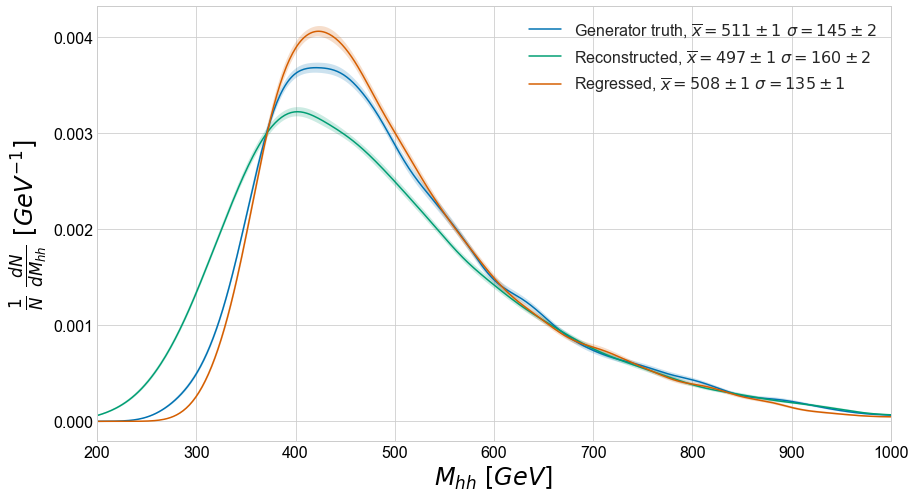

In [93]:
from lumin.plotting.data_viewing import plot_kdes_from_bs
plot_kdes_from_bs(x, {s:bs_stats[s] for s in bs_stats if 'reco' in s or 'gen' in s or 'pred' in s},
                  {'gen': {'condition': 'Generator truth', 'ci': 'sd'},
                   'reco': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$M_{hh}$', units='GeV')

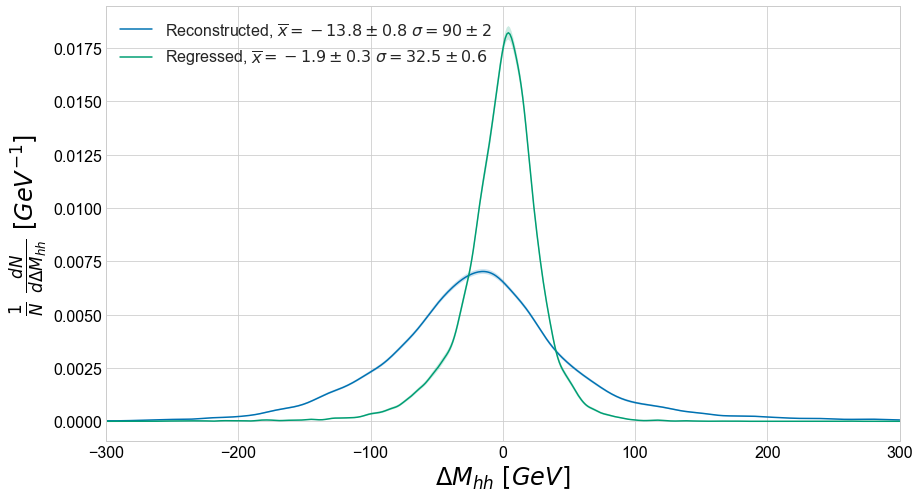

In [95]:
plot_kdes_from_bs(x_delta, {s:bs_stats[s] for s in bs_stats if 'delta' in s},
                  {'reco_delta': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_delta': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{hh}$', units='GeV')

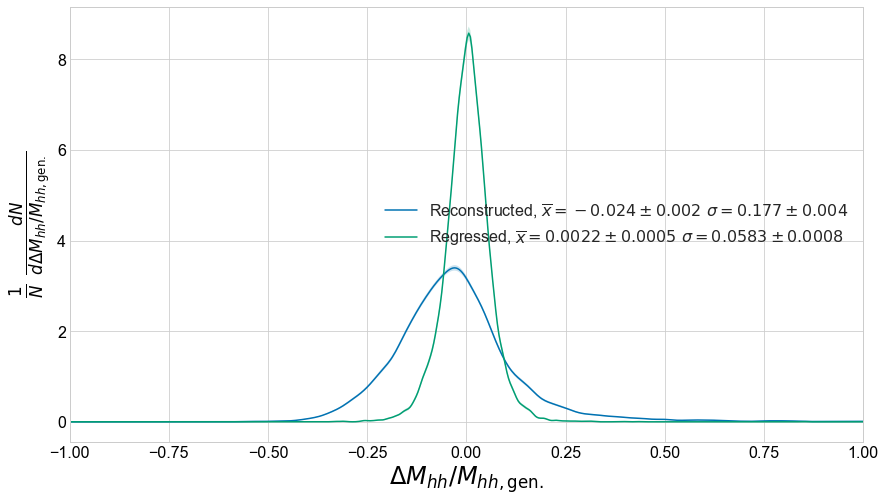

In [96]:
plot_kdes_from_bs(x_pull, {s:bs_stats[s] for s in bs_stats if 'pull' in s},
                  {'reco_pull': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_pull': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{hh}/M_{hh, \mathrm{gen.}}$')

## Interpretation 
So, we now have a model which improves our estimate of the di-Higgs mass by about two thirds. One might very well be interested in what information the ensemble is using to get such an improvement. In the same way as we used permutation importance to rank features with random forests, we can use the same technique to rank features with our ensemble.

In [97]:
ensemble = Ensemble()
ensemble.load(name)

In [98]:
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

49124 candidates loaded


,t_0_mass,b_0_mass,b_1_mass,h_tt_mass,h_bb_mass,diH_mass,hT,sT,centrality,eVis,...,b_1_pz,diH_px,diH_py,diH_pz,t_1_px,t_1_py,t_1_pz,mPT_pT,nJets,gen_target
0,4.410120,16.697281,13.357175,153.978546,151.454391,475.819366,316.021942,502.589569,0.630579,533.359436,...,54.189407,93.271088,-15.662423,354.598236,19.844599,15.511989,22.521070,161.379715,1.0,396.926361
1,0.000001,33.631935,7.227210,119.777473,127.714684,407.808655,492.123230,560.098816,0.638596,850.725220,...,-18.073977,-198.014862,48.782925,-181.112518,-54.945477,18.819294,29.007900,9.896618,1.0,427.752045
2,1.817759,16.902903,11.056087,143.336227,114.252213,696.787415,797.166687,959.854919,0.271856,3169.371094,...,311.979706,-85.127342,2.564148,1120.117432,31.910501,63.745674,66.598724,91.401512,1.0,625.834106
3,5.727513,13.131482,11.938969,89.615585,102.447136,352.568207,267.354492,361.035980,0.574201,544.450928,...,82.944931,17.390404,33.322418,174.485611,38.339710,30.246012,-23.974470,44.847542,1.0,488.548828
4,5.896853,30.414080,18.575914,397.409241,134.739990,962.254150,548.899353,859.926392,0.525363,1318.360840,...,-26.633799,113.498878,-15.603452,491.012970,-47.449574,140.386765,432.912506,162.838318,1.0,1025.427856


Top ten most important features:
      Feature  Importance  Uncertainty
0   diH_mass    9.374584     0.790659
1  h_bb_mass    3.070268     0.425473
2     t_1_px    2.030181     0.202903
3     t_1_pz    1.889308     0.197278
4  h_tt_mass    1.234170     0.136430
5    h_tt_pz    0.999274     0.087488
6    h_bb_pz    0.799345     0.086248
7     mPT_pT    0.766700     0.109128
8     b_0_pz    0.656377     0.084047
9    h_bb_px    0.592491     0.071461


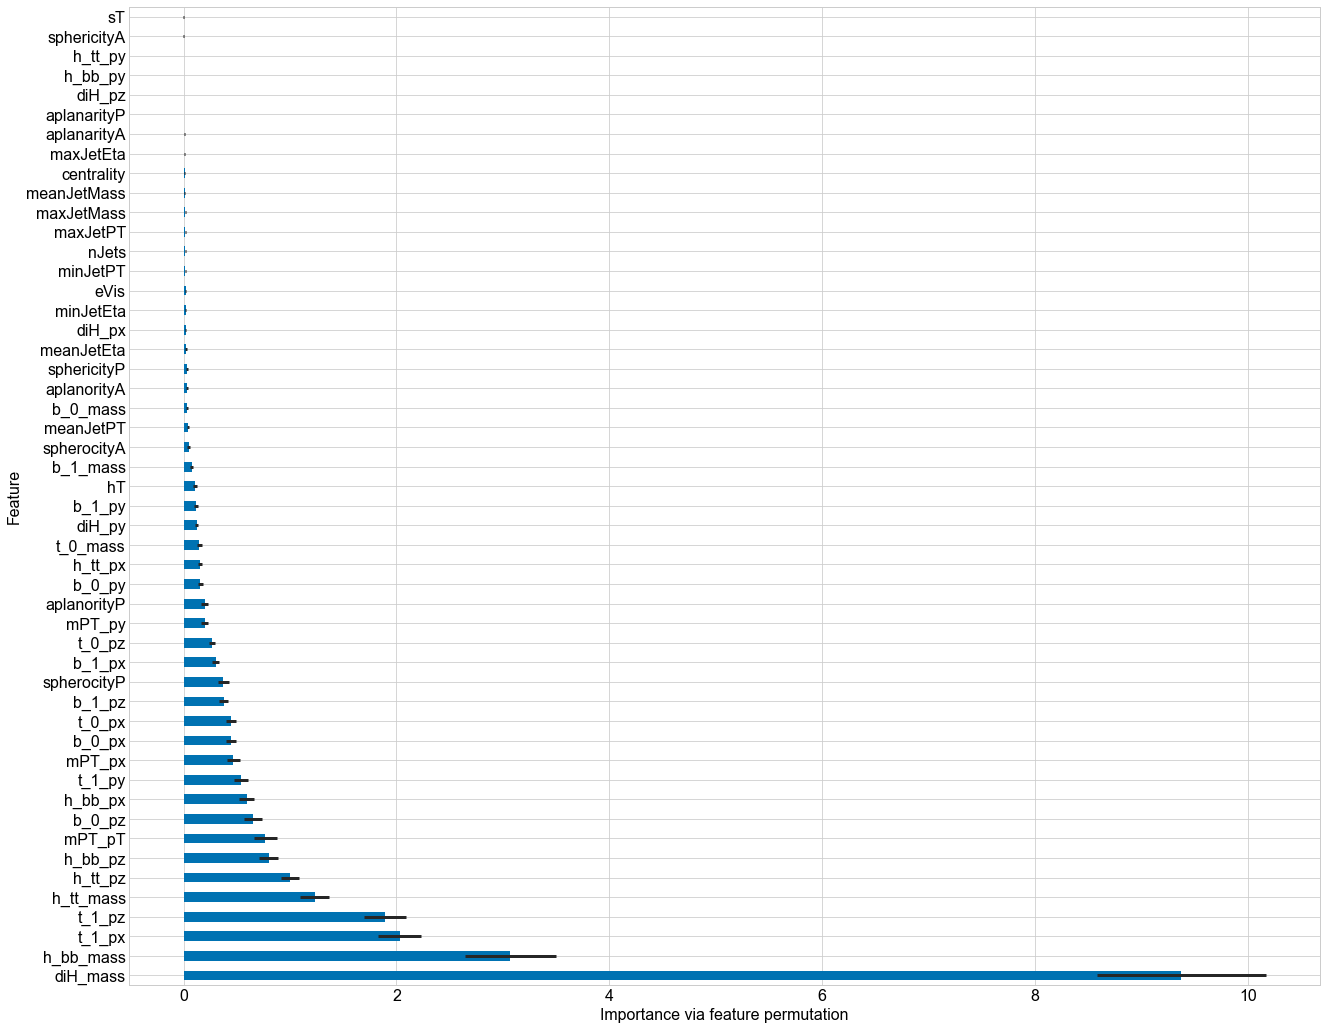

In [101]:
_ = ensemble.get_feat_importance(train_fy)

As expected, the reconstructed di-Higgs mass providing most of the work, however other features are also quite important and are effectively used to calibrate the reconstructed mass to account for the poor precision of the tau measurements; `t_1` corresponds to $\tau\rightarrow\nu_\tau\nu_\mu\mu$ and so has the greatest amount of mis-measurement due to the two neutrinos.